In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('datas/034220.KS.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-06-09,26800.0,27750.0,26800.0,27350.0,25536.921875,1167238.0
1,2014-06-10,27950.0,29300.0,27900.0,29100.0,27170.912109,3829589.0
2,2014-06-11,29400.0,29850.0,29250.0,29500.0,27544.396484,2574407.0
3,2014-06-12,29450.0,29600.0,29200.0,29550.0,27591.080078,1780893.0
4,2014-06-13,29450.0,29750.0,29050.0,29550.0,27591.080078,1093988.0


In [4]:
df.shape

(1225, 7)

In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1220,2019-05-30,16450.0,16650.0,16350.0,16550.0,16550.0,1841176.0
1221,2019-05-31,16500.0,17300.0,16450.0,17100.0,17100.0,2085161.0
1222,2019-06-03,16950.0,17050.0,16600.0,16900.0,16900.0,2302256.0
1223,2019-06-04,16950.0,17200.0,16850.0,17000.0,17000.0,1074366.0
1224,2019-06-05,17250.0,17400.0,16800.0,16850.0,16850.0,1572824.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1225 entries, 0 to 1224
Data columns (total 7 columns):
Date         1225 non-null object
Open         1159 non-null float64
High         1159 non-null float64
Low          1159 non-null float64
Close        1159 non-null float64
Adj Close    1159 non-null float64
Volume       1159 non-null float64
dtypes: float64(6), object(1)
memory usage: 67.1+ KB


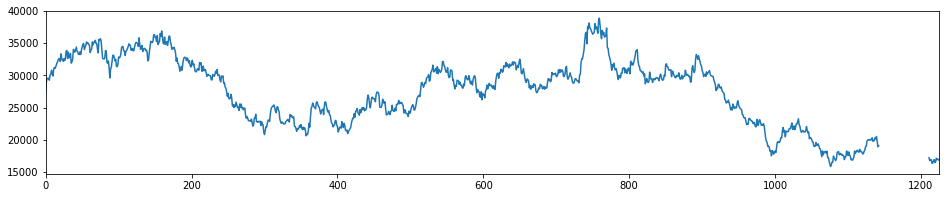

In [7]:
df['Close'].plot(figsize=(16,3))

In [8]:
df1 = df[['Date', 'Adj Close']]

In [23]:
df1.head()

,Date,Adj Close
0,2014-06-09,25536.921875
1,2014-06-10,27170.912109
2,2014-06-11,27544.396484
3,2014-06-12,27591.080078
4,2014-06-13,27591.080078


In [24]:
df1.columns(['ds', 'y'])

TypeError: 'Index' object is not callable

In [9]:
df1 = df1.rename(columns={'Date':'ds'})
df1 = df1.rename(columns={'Adj Close':'y'})

In [10]:
df1.shape

(1225, 2)

In [61]:
df1_train = df1[:1000]
df1_test = df1[1000:]

## prophet

In [62]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

In [63]:
m = Prophet()
m.fit(df1_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



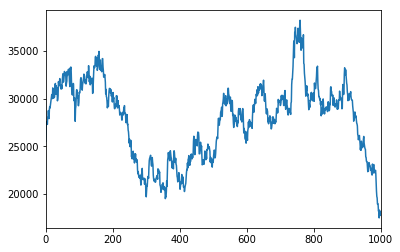

In [64]:
df1_train['y'].plot()

In [65]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1360,2019-06-30
1361,2019-07-01
1362,2019-07-02
1363,2019-07-03
1364,2019-07-04


In [66]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1360,2019-06-30,5519.463422,-4644.233822,17139.222751
1361,2019-07-01,8695.397411,-1806.535749,20680.620283
1362,2019-07-02,8862.898730,-1051.265050,20831.151789
1363,2019-07-03,8986.779786,-1799.517540,20989.123717
1364,2019-07-04,8972.620003,-1412.781219,20813.850376


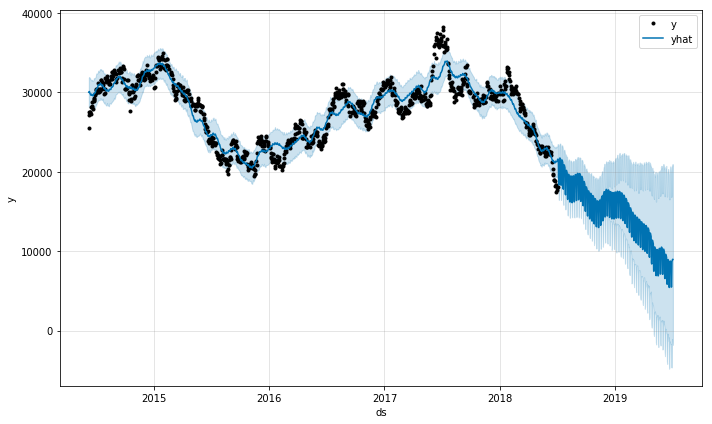

In [67]:
fig1 = m.plot(forecast)
plt.legend()

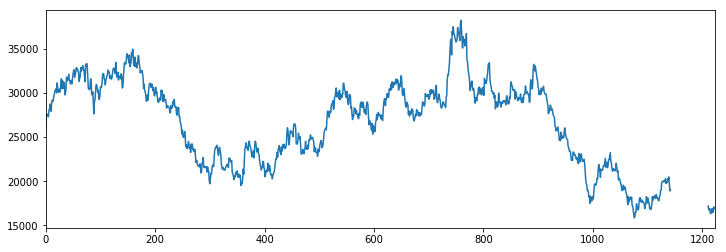

In [71]:
df['Adj Close'].plot(figsize=(12,4))

In [72]:
df1.shape

(1225, 2)

## Keras 로 표현

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.


In [12]:
high_prices = df['High'].values
low_prices = df['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [13]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [14]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

In [15]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=20)

Train on 1057 samples, validate on 117 samples
Epoch 1/20
